<a href="https://colab.research.google.com/github/tozanni/nma_wcst_rl/blob/main/human_rl_wcst.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Using RL to Model Wisconsin Card Sorting Task

**Original notebook credits (Nback Task):**

__Content creators:__ Morteza Ansarinia, Yamil Vidal
__Production editor:__ Spiros Chavlis

**WCST notebook credits:**

__RL Environment:__ Eduardo Ramirez, Dieu-Donné Fangnon, Thao Nguyen

__WCST original implementation:__ Pauline Bock


---
# Objective

- This project aims to use behavioral data to train an agent and then use the agent to investigate data produced by human subjects. Having a computational agent that mimics humans in such tests, we will be able to compare its mechanics with human data.

- In another conception, we could fit an agent that learns many cognitive tasks that require abstract-level constructs such as executive functions. This is a multi-task control problem.




---
# Setup

In [1]:
# @title Install dependencies
!pip install jedi --quiet
!pip install --upgrade pip setuptools wheel --quiet
!pip install dm-acme[jax] --quiet
!pip install dm-sonnet --quiet
!pip install trfl --quiet
!pip install numpy==1.23.3 --quiet --ignore-installed
!pip uninstall seaborn -y --quiet
!pip install seaborn --quiet

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
numba 0.56.4 requires numpy<1.24,>=1.18, but you have numpy 1.25.1 which is incompatible.
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
chex 0.1.82 requires numpy>=1.25.0, but you have numpy 1.23.3 which is incompatible.


In [3]:
# Imports
import time
import numpy as np
import pandas as pd
import sonnet as snt
import seaborn as sns
import matplotlib.pyplot as plt

import dm_env

import acme
from acme import specs
from acme import wrappers
from acme import EnvironmentLoop
from acme.agents.tf import dqn
from acme.utils import loggers

/usr/local/lib/python3.10/dist-packages/reverb/platform/default/ensure_tf_install.py:53: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if (distutils.version.LooseVersion(version) <
/usr/local/lib/python3.10/dist-packages/tensorflow_probability/python/__init__.py:57: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if (distutils.version.LooseVersion(tf.__version__) <


In [3]:
# @title Figure settings
from IPython.display import clear_output, display, HTML
%matplotlib inline
sns.set()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


---
# Background

- Cognitive scientists use standard lab tests to tap into specific processes in the brain and behavior. Some examples of those tests are Stroop, N-back, Digit Span, TMT (Trail making tests), and WCST (Wisconsin Card Sorting Tests).

## Datasets

This notebook works on simulated data only.

## Wisconsin Card Sorting task (WCST)

TODO: Describe Task

TODO: Describe metrics

---
# Cognitive Tests Environment


## Implementation scheme


### Define a random agent

For more information you can refer to NMA-DL W3D2 Basic Reinforcement learning.


In [4]:
class RandomAgent(acme.Actor):

  def __init__(self, environment_spec):
    """Gets the number of available actions from the environment spec."""
    self._num_actions = environment_spec.actions.num_values

  def select_action(self, observation):
    """Selects an action uniformly at random."""
    action = np.random.randint(self._num_actions)
    return action

  def observe_first(self, timestep):
    """Does not record as the RandomAgent has no use for data."""
    pass

  def observe(self, action, next_timestep):
    """Does not record as the RandomAgent has no use for data."""
    pass

  def update(self):
    """Does not update as the RandomAgent does not learn from data."""
    pass

### WCST utility methods

From [Pauline Bock's repository](https://github.com/PaulineBock/WCSTDehaeneChangeux)

In [5]:
from tensorflow import float32
"""
Module WCST (Imported as regular functions)

Generates cards for the different WCST tasks.

Pauline Bock
09-04-2019
"""
import numpy as np
import random
import sys

def perception(nb_dim, nb_templates, nb_features):
    """
    Create and return reference cards.
    """
    percep_shape = (nb_templates, nb_dim, nb_features)
    percep = np.zeros(percep_shape, dtype=float)

    #Random generating of binary features
    for i in range(0, nb_templates):
        for j in range(0, nb_dim):
            percep[i][j].put([i], 1)

    return percep

def response_item_Reasoning(nb_dim, nb_features, m_percep, reasoning_list):
    """
    Create and return a card for Reasoning version that was not already created. (36 ambiguous cards).
    """
    item = create_card_Reasoning(nb_dim, nb_features)
    #check if different from reference cards
    eq = check_equality(m_percep, item, nb_dim)
    unique = check_unity(item, reasoning_list)

    while(eq == 1 or unique==1):
        item = create_card_Reasoning(nb_dim, nb_features)
        eq = check_equality(m_percep, item, nb_dim)
        unique = check_unity(item, reasoning_list)

    reasoning_list.append(item)
    return item

def check_unity(item, cardlist):
    if inList(item, cardlist) == True:
        return 1
    else:
        return 0

def create_card_Reasoning(nb_dim, nb_features):
    """
    Create a card with ambiguity.
    """
    item_shape = (nb_dim, nb_features)
    item = np.zeros(item_shape, dtype=float)

    r = [0,1,2]
    #random 2 different dimensions
    idim1 = random.randint(0,2)
    dim1 = r[idim1]
    r.remove(dim1)
    idim2 = random.randint(0,len(r)-1)
    dim2 = r[idim2]
    r.remove(dim2)
    dim3 = r[0]

    feat = random.randint(0,3)
    feat2 = random.randint(0,3)
    while(feat == feat2):
        feat2 = random.randint(0,3)

    np.put(item[dim1],[feat], 1)
    np.put(item[dim2],[feat], 1)
    np.put(item[dim3],[feat2], 1)

    return item


def check_equality(m_percep, item, nb_dim):
    """
    Check if the card is different from the reference ones.
    """
    for temp in range(0, m_percep.shape[0]):
        dim_eq = 0
        for dim in range(0, nb_dim):
            if np.array_equal(m_percep[temp][dim], item[dim]):
                dim_eq +=1

        if dim_eq == nb_dim:
            return 1

    return 0

def inList(array, arraylist):
    for element in arraylist:
        if np.array_equal(element, array):
            return True
    return False


### Environment

The following cell implments an envinronment for the WCST:
- Rewards the agent once the action was correct (i.e., a normative model of the environment).
- **Future work**: Receives human data and returns what participants performed as the observation.

In [6]:
class WCST_Env(dm_env.Environment):
    ACTIONS = [0, 1, 2, 3]

    def __init__(self,seed=1):

        self.episode_steps = 36  #36 cards or steps per episode

        #Init WCST variables
        self.nb_dim = 3
        self.nb_features = 4
        self.nb_templates = self.nb_features
        r = 3  #rules number, we have 3 rules
        self.m_percep = perception(self.nb_dim, self.nb_templates, self.nb_features)

        #Episode specific (each 36 steps)
        self._reset_next_step = True
        self._current_step = 0  #Current episode step counter
        self._action_history = []
        self.nbTS = 0
        self.nb_win = 0
        self.t_criterion = 0
        self.t_err = 0
        self.criterions = []
        self.winstreak = 0
        self.seen_cards = []
        self.rule = 0
        self.np_data = []
        self.v_data = []

    def new_card(self):
        v_data = [] #list type
        np_data = response_item_Reasoning(self.nb_dim, self.nb_features, self.m_percep, self.seen_cards) #Modified WCST version

        #Transform into a vector
        for arr in np_data:
            for e in arr:
                v_data.append(e)

        #Save last card info
        self.np_data = np_data
        self.v_data = v_data

        return np_data, v_data

    def reset(self):
        self._reset_next_step = False

        self._current_step = 0  #Current episode step counter
        self._action_history = []
        self.nbTS = 0
        self.nb_win = 0
        self.t_criterion = 0
        self.t_err = 0
        self.criterions = []
        self.winstreak = 0
        self.seen_cards = []
        self.rule = 0
        self.np_data = []
        self.v_data = []

        self._action_history.clear()

        #Deal new card
        return dm_env.restart(self._observation())

    def _episode_return(self):
      return 0.0

    def rule_switching(self, rule):
        """
        Serially changing the rules : color - form - number.
        """
        if rule!=2:
            rule = rule+1
        else:
            rule = 0
        return rule

    def external_feedback(self, action):
        """
        Returns a true reward according to the success or not of the card chosen.
        """
        response_card = self.np_data
        reference_cards = self.m_percep
        right_action_i = 0

        #print("Determine reward for rule:", self.rule, "and card: ")
        #print(response_card)

        for i in range(0, self.nb_templates):

            if np.array_equal(reference_cards[i][self.rule], response_card[self.rule]):
                right_action_i = i

        if right_action_i == action:
            #Original DaheneChangeux
            #0 to decrease error activity
            #return 0.
            return 0.
        else:
            #Original DaheneChangeux
            #1 to activate error cluster
            #return 1.
            return -1.

    def step(self, action: int):

        if self._reset_next_step:
            return self.reset()

        agent_action = WCST_Env.ACTIONS[action]

        #Compute reward
        step_reward = self.external_feedback(agent_action)
        #print("Reward:", step_reward)

        ##Winstreak count
        if step_reward == 0.:
            self.t_err = 0
            self.nb_win += 1
            self.winstreak += 1
            #ptrial.append(1)
            #ntrial.append(0)

        if step_reward == -1.:
            self.t_criterion += 1
            self.t_err += 1

            #Note: In the original code 0 means OK and 1 means error,
            #in this implementation 0. means OK and -1. means error.
            self.winstreak = 0
            #ptrial.append(0)
            #ntrial.append(1)

        # Criterion test
        # After 3 wins, then change the rule
        if self.winstreak==3:
            self.rule = self.rule_switching(self.rule)
            self.criterions.append(self.t_criterion)
            #Reset some variables and increment nbTS
            self.t_criterion = 0
            self.winstreak = 0
            self.nbTS +=1
            #print("winstreak=3, New rule is ", self.rule, "NbTS=", self.nbTS)
        else:
            #print("Winstreak=", self.winstreak)
            pass

        self._action_history.append(agent_action)
        self._current_step += 1

        # Check for termination.
        if self.nbTS >= 6 or self._current_step == (self.episode_steps - 1):
            self._reset_next_step = True
            #print("B. Return last observation and terminate, NbTS=", self.nbTS)
            return dm_env.termination(reward=self._episode_return(), observation=self._observation())
        else:
            #Send reward to agent and a new observation
            #print("A. Step: ", self._current_step, "Return next observation")
            return dm_env.transition(reward=step_reward, observation=self._observation())

    def observation_spec(self):
        return dm_env.specs.Array(
            shape=(3, 4),
            dtype=np.float32,
            name='card'
        )

    def action_spec(self):
        return dm_env.specs.DiscreteArray(
            num_values=len(WCST_Env.ACTIONS),
            dtype=np.int32,
            name='action')
        pass

    def _observation(self):
        # agent observes only the current trial

        #INPUT new card, (Environment)
        #print("Calling new_card...")
        np_data, card = self.new_card()
        #print("New card is v_data", card)
        #return data in numpy format (3,4)
        obs = np_data
        return obs

    @staticmethod
    def create_environment():
        """Utility function to create a N-back environment and its spec."""

        # Make sure the environment outputs single-precision floats.
        environment = wrappers.SinglePrecisionWrapper(WCST_Env())

        # Grab the spec of the environment.
        environment_spec = specs.make_environment_spec(environment)
        return environment, environment_spec


### Initialize the environment and the agent

Draw a sample card

In [106]:
#timestep = env.reset()
#timestep.observation

array([[0., 0., 0., 1.],
       [0., 1., 0., 0.],
       [0., 0., 0., 1.]], dtype=float32)

### Run the loop for the Random Agent and plot episode returns

actions:
 DiscreteArray(shape=(), dtype=int32, name=action, minimum=0, maximum=3, num_values=4)
observations:
 Array(shape=(3, 4), dtype=dtype('float32'), name='card')
rewards:
 Array(shape=(), dtype=dtype('float32'), name='reward')
DONE


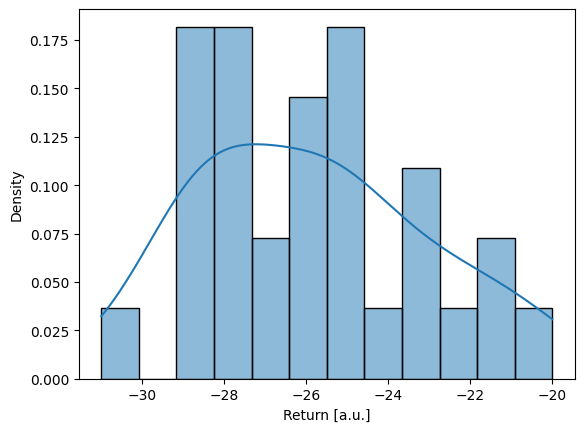

In [7]:
env, env_spec = WCST_Env.create_environment()
agent = RandomAgent(env_spec)
print('actions:\n', env_spec.actions)
print('observations:\n', env_spec.observations)
print('rewards:\n', env_spec.rewards)

# fitting parameters
n_episodes = 30
n_total_steps = 0
log_loss = False
n_steps = n_episodes * 36
all_returns = []

# main loop
for episode in range(n_episodes):
  episode_steps = 0
  episode_return = 0
  episode_loss = 0

  start_time = time.time()

  timestep = env.reset()

  # Make the first observation.
  #agent.observe_first(timestep)

  # Run an episode
  while not timestep.last():

    # Generate an action from the agent's policy and step the environment.
    action = agent.select_action(timestep.observation)
    timestep = env.step(action)

    # Have the agent observe the timestep and let the agent update itself.
    agent.observe(action, next_timestep=timestep)
    agent.update()

    # Book-keeping.
    episode_steps += 1
    n_total_steps += 1
    episode_return += timestep.reward

    if n_steps is not None and n_total_steps >= n_steps:
      break

  # Collect the results and combine with counts.
  steps_per_second = episode_steps / (time.time() - start_time)
  result = {
      'episode': episode,
      'episode_length': episode_steps,
      'episode_return': episode_return,
  }
  if log_loss:
    result['loss_avg'] = episode_loss/episode_steps

  all_returns.append(episode_return)

  # Log the given results.
  #print(result)

  if n_steps is not None and n_total_steps >= n_steps:
    break

print("DONE")

#clear_output()
# Histogram of all returns
plt.figure()
sns.histplot(all_returns, stat="density", kde=True, bins=12)
plt.xlabel('Return [a.u.]')
plt.ylabel('Density')
plt.show()


In [145]:
all_returns

[]

## DQN Agent


In [21]:
env, env_spec = WCST_Env.create_environment()

def dqn_make_network(action_spec: specs.DiscreteArray) -> snt.Module:
  return snt.Sequential([
      snt.Flatten(),
      snt.nets.MLP([50, 50, action_spec.num_values]),
  ])

# construct a DQN agent
agent = dqn.DQN(
    environment_spec=env_spec,
    network=dqn_make_network(env_spec.actions),
    epsilon=[0.99],
    logger=loggers.InMemoryLogger(),
    checkpoint=False,
)

# training loop
n_episodes = 100
loop = EnvironmentLoop(env, agent, logger=loggers.InMemoryLogger())
loop.run(n_episodes)

# print logs
logs = pd.DataFrame(loop._logger._data)
logs.tail()

,episode_length,episode_return,steps_per_second,episodes,steps
95,35,-27.0,307.614988,96,3360
96,35,-23.0,317.956768,97,3395
97,35,-23.0,327.640508,98,3430
98,35,-27.0,299.563187,99,3465
99,35,-27.0,291.295386,100,3500


Now, we run the environment loop with the DQN agent and print the training log.

<Axes: >

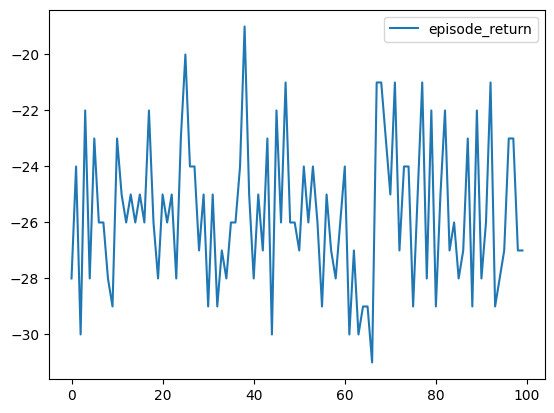

In [22]:
logs[['episode_return']].astype('float32').plot()

DQN Agent (Custom loop)

DONE


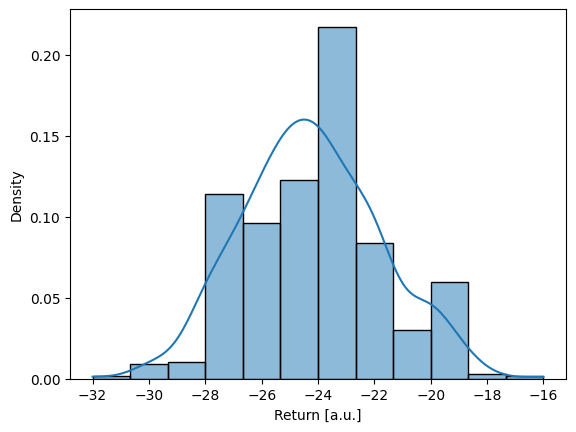

In [15]:
env, env_spec = WCST_Env.create_environment()

def dqn_make_network(action_spec: specs.DiscreteArray) -> snt.Module:
  return snt.Sequential([
      snt.Flatten(),
      snt.nets.MLP([50, 50, action_spec.num_values]),
  ])

# construct a DQN agent
agent = dqn.DQN(
    environment_spec=env_spec,
    network=dqn_make_network(env_spec.actions),
    epsilon=[0.5],
    logger=loggers.InMemoryLogger(),
    checkpoint=False,
)

# fitting parameters
n_episodes = 500
n_total_steps = 0
log_loss = False
n_steps = n_episodes * 36
all_returns = []

# main loop
for episode in range(n_episodes):
  episode_steps = 0
  episode_return = 0
  episode_loss = 0

  start_time = time.time()

  timestep = env.reset()

  # Make the first observation.
  agent.observe_first(timestep)

  # Run an episode
  while not timestep.last():

    # Generate an action from the agent's policy and step the environment.
    action = agent.select_action(timestep.observation)
    timestep = env.step(action)

    # Have the agent observe the timestep and let the agent update itself.
    agent.observe(action, next_timestep=timestep)
    agent.update()

    # Book-keeping.
    episode_steps += 1
    n_total_steps += 1
    episode_return += timestep.reward

    if n_steps is not None and n_total_steps >= n_steps:
      break

  # Collect the results and combine with counts.
  steps_per_second = episode_steps / (time.time() - start_time)
  result = {
      'episode': episode,
      'episode_length': episode_steps,
      'episode_return': episode_return,
  }
  if log_loss:
    result['loss_avg'] = episode_loss/episode_steps

  all_returns.append(episode_return)

  # Log the given results.
  #print(result)

  if n_steps is not None and n_total_steps >= n_steps:
    break

print("DONE")

#clear_output()
# Histogram of all returns
plt.figure()
sns.histplot(all_returns, stat="density", kde=True, bins=12)
plt.xlabel('Return [a.u.]')
plt.ylabel('Density')
plt.show()